<a href="https://colab.research.google.com/github/superphantomman/Projekt-uczenie-maszynowe/blob/main/projekt_uczenie_maszynowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Treść zadania:**
Utworzyć model uczenia maszynowego do przewidzenia. Do przewidywania wartość napiwków w zależności od następujących parametrów

*   total_bill
*   sex
*   smoker
*   day
*   time
*   size


Moje rozwiązanie zadania oparłem na sieciach neuronowych. Nie jest to idealny model pod małą porcje danych, ale przy większej ilości, powinien dawać lepsze wyniki.

Importuje następujące biblioteki w pythonie:


*   tensorflow
*   pandas
*   matplotlib



In [11]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Pobieram dane z pliku csv za pomocą biblioteki pandas oraz dziele je na zestawy treningowe i testowe.

**Format CSV :** *,total_bill,tip,sex,smoker,day,time,size*

In [12]:
dataframe = pd.read_csv('homework_data/tips.csv')

dataframe = pd.get_dummies(dataframe, columns=['day'], prefix='day')

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)


Funkcja do tworzenia zestawu danych tensorflowe oraz wywyłania funkcji

In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('tip')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

Definiowanie kolumn wykorzytanych"

*   numeryczne kolumny
*   kategoryczne kolumny
*   kolumna dzień ( osobno potraktowana, ze względu na wielowartościowość )






In [14]:
numeric_columns = ['total_bill', 'size']

feature_columns = [tf.feature_column.numeric_column(header) for header in numeric_columns]

day_columns = [tf.feature_column.numeric_column(col) for col in dataframe.columns if 'day_' in col]
feature_columns.extend(day_columns)

# Remaining categorical columns
categorical_columns = ['sex', 'smoker', 'time']

for col_name in categorical_columns:
    categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(
        col_name, dataframe[col_name].unique())
    indicator_column = tf.feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

Tworzenie, kompilacja i trenowanie modelu

In [15]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),  # Use MeanSquaredError for regression
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Train model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)


Epoch 1/10
5/5 [==============================] - 1s 68ms/step - loss: 1.8661 - mean_absolute_error: 0.9930 - val_loss: 1.6189 - val_mean_absolute_error: 1.0099
Epoch 2/10
5/5 [==============================] - 0s 5ms/step - loss: 2.0411 - mean_absolute_error: 1.0355 - val_loss: 1.3075 - val_mean_absolute_error: 0.9022
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 1.3453 - mean_absolute_error: 0.8288 - val_loss: 0.7987 - val_mean_absolute_error: 0.6673
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 1.1461 - mean_absolute_error: 0.7732 - val_loss: 0.8791 - val_mean_absolute_error: 0.7621
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 1.0624 - mean_absolute_error: 0.7400 - val_loss: 0.8615 - val_mean_absolute_error: 0.7491
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 1.0145 - mean_absolute_error: 0.7354 - val_loss: 0.8810 - val_mean_absolute_error: 0.7458
Epoch 7/10
5/5 [=======================

Deklaracja funkcji wykorzystanej do wizualizacji histori treningu

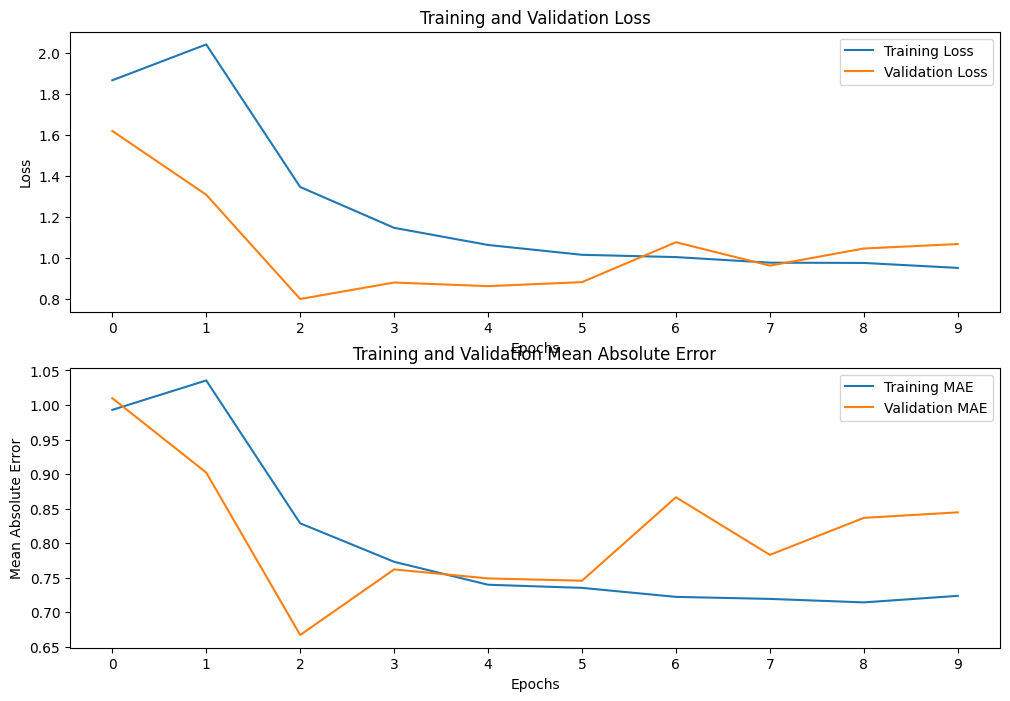

In [16]:
def plot_training_history(history):
    hist = history.history
    epochs = history.epoch

    plt.figure(figsize=(12, 8))

    # Plot loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, hist['loss'], label='Training Loss')
    plt.plot(epochs, hist['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xticks(epochs)  # Ensure epochs are displayed as integers

    plt.subplot(2, 1, 2)
    plt.plot(epochs, hist['mean_absolute_error'], label='Training MAE')
    plt.plot(epochs, hist['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.title('Training and Validation Mean Absolute Error')
    plt.xticks(epochs)  # Ensure epochs are displayed as integers

    plt.show()

plot_training_history(history)


Ocena modelu względem zestawu treningowego.

In [17]:
test_loss, test_mae = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

2/2 [==============================] - 0s 23ms/step - loss: 1.3711 - mean_absolute_error: 0.8290
Test Loss: 1.3711379766464233
Test MAE: 0.8289846181869507
